In [1]:
#Import the right libraries
import pandas as pd
import dgl
import numpy as np
import networkx as nx
import torch
from dgl.data.utils import save_graphs
from dgl.data.utils import load_graphs
import umap.umap_ as umap
import matplotlib.pyplot as plt
import json
import pickle

Using backend: pytorch


In [2]:
# Retrieve model
trained_model = torch.load('model.pth')

In [3]:
# Retrieve graph
g = load_graphs("dgl_graph")
G = g[0][0]

# Start of the github file

In [4]:
import scipy.io
import urllib.request
import dgl
import math
import numpy as np
from hgt_model import *
import argparse

In [5]:
torch.manual_seed(0)

# Retrieve embeddings values
n_epoch = 1
n_hid = 256
n_inp = 256
clip = 1.0
max_lr = 1e-3

In [6]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [7]:
def train(model, G):
    best_val_acc = torch.tensor(0)
    best_test_acc = torch.tensor(0)
    train_step = torch.tensor(0)
    for epoch in np.arange(n_epoch) + 1:
        model.train()
        logits, h = model(G, 'investor/company')
        
        company_embeddings = h['company']
        investor_company_embeddings = h['investor/company']

        # The loss is computed only for labeled nodes.
#         loss = F.cross_entropy(logits[train_idx], labels[train_idx].to(device))
        loss = F.cross_entropy(logits[train_idx], labels[train_idx])
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_step += 1
        scheduler.step(train_step)
        if epoch % 5 == 0:
            model.eval()
            logits, h = model(G, 'investor/company')
            pred   = logits.argmax(1).cpu()
            train_acc = (pred[train_idx] == labels[train_idx]).float().mean()
            val_acc   = (pred[val_idx]   == labels[val_idx]).float().mean()
            test_acc  = (pred[test_idx]  == labels[test_idx]).float().mean()
            if best_val_acc < val_acc:
                best_val_acc = val_acc
                best_test_acc = test_acc
            print('Epoch: %d LR: %.5f Loss %.4f, Train Acc %.4f, Val Acc %.4f (Best %.4f), Test Acc %.4f (Best %.4f)' % (
                epoch,
                optimizer.param_groups[0]['lr'], 
                loss.item(),
                train_acc.item(),
                val_acc.item(),
                best_val_acc.item(),
                test_acc.item(),
                best_test_acc.item(),
            ))
            
    return company_embeddings, investor_company_embeddings

In [8]:
# Our way
different_edge = ('investor/company', 'different_invests_in', 'company')
same_edge = ('investor/company', 'same_invests_in', 'investor/company')

different_labels = G[different_edge].edges()
same_labels = G[same_edge].edges()

pid = G[different_edge].edges()[0]
labels = G[different_edge].edges()[1]

print(pid)
print(labels)

tensor([   0,    0,    0,  ..., 7882, 7882, 7882])
tensor([9181, 9701, 9676,  ..., 7817, 7818, 7819])


In [9]:
# generate train/val/test split
shuffle = np.random.permutation(pid)
train_idx = torch.tensor(shuffle[0:800]).long()
val_idx = torch.tensor(shuffle[800:900]).long()
test_idx = torch.tensor(shuffle[900:]).long()

In [10]:
node_dict = {}
edge_dict = {}

for ntype in G.ntypes:
    node_dict[ntype] = len(node_dict)
for etype in G.etypes:
    edge_dict[etype] = len(edge_dict)
    G.edges[etype].data['id'] = torch.ones(G.number_of_edges(etype), dtype=torch.long) * edge_dict[etype] 

#     Random initialize input feature
for ntype in G.ntypes:
    emb = nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), 256), requires_grad = False)
    nn.init.xavier_uniform_(emb)
    G.nodes[ntype].data['inp'] = emb
    

# G = G.to(device)

In [11]:
model = HGT(G,
            node_dict, edge_dict,
            n_inp=n_inp,
            n_hid=n_hid,
            n_out=labels.max().item()+1,
            n_layers=2,
            n_heads=4,
            use_norm = True)#.to(device)
optimizer = torch.optim.AdamW(model.parameters())

checkpoint = torch.load("model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, total_steps=n_epoch, max_lr = max_lr)

print('Training HGT with #param: %d' % (get_n_params(model)))

company_embeddings, investor_company_embeddings = train(model, G)

Training HGT with #param: 3961687


/home/ramon/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [12]:
print(company_embeddings)
print(investor_company_embeddings)

tensor([[ 3.4103e-05,  4.4151e-01,  5.9194e-01,  ..., -2.0550e+00,
         -2.1744e-02,  1.9211e+00],
        [ 1.1779e-01,  5.5825e-01,  8.3571e-01,  ..., -2.2643e+00,
         -3.0674e-01,  1.9657e+00],
        [-1.0884e-01,  6.6912e-01,  9.6457e-01,  ..., -1.9288e+00,
         -1.9146e-01,  9.0308e-02],
        ...,
        [ 3.4198e-01,  4.4667e-01,  6.9273e-01,  ..., -2.4912e-01,
         -2.5848e-01,  1.9479e+00],
        [-1.5015e-01,  6.0357e-01,  7.2656e-01,  ..., -2.2543e+00,
          6.6173e-02,  1.3147e-01],
        [-3.0216e-02,  5.3443e-01,  7.4951e-01,  ..., -2.1275e+00,
         -1.3842e-01,  2.0312e+00]], grad_fn=<NativeLayerNormBackward>)
tensor([[ 1.2579, -1.4894,  0.1183,  ...,  0.2130, -1.3843, -1.1353],
        [-0.5336,  2.0064,  0.0856,  ..., -0.3866,  1.9477, -1.3137],
        [-0.8462, -0.0798, -0.1972,  ..., -0.0497, -0.5855, -0.0407],
        ...,
        [-0.1891,  1.5836, -1.5994,  ...,  0.8147, -0.6761, -0.1816],
        [ 0.5995,  0.9378, -1.0137,  ...

# Apply UMAP for dimensionality reduction

In [13]:
reducer = umap.UMAP()
company_embeddings = company_embeddings.detach().numpy()
investor_company_embeddings = investor_company_embeddings.detach().numpy()

company_embeddings = reducer.fit_transform(company_embeddings)
investor_company_embeddings = reducer.fit_transform(investor_company_embeddings)

print(company_embeddings)
print(investor_company_embeddings)

[[ 2.8511984  4.9711328]
 [12.6158905  5.0920553]
 [-1.1429101 -2.6001184]
 ...
 [ 2.630107   5.2896667]
 [11.791956   4.123386 ]
 [ 3.9484985  5.4020424]]
[[13.03264  19.691486]
 [12.329509 21.0606  ]
 [14.541085 20.389605]
 ...
 [12.651039 21.823622]
 [12.52789  22.146973]
 [12.903037 18.612228]]


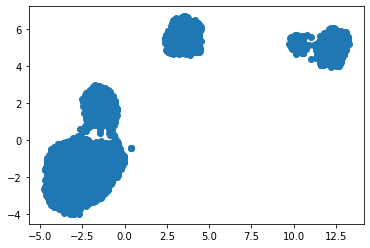

In [14]:
plt.scatter(company_embeddings[:, 0], company_embeddings[:, 1],)
plt.show()

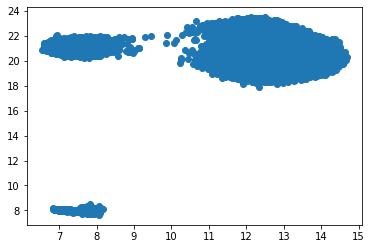

In [15]:
plt.scatter(investor_company_embeddings[:, 0], investor_company_embeddings[:, 1],)
plt.show()

In [16]:
joined_embeddings = np.concatenate((company_embeddings, investor_company_embeddings), axis=0)
print(joined_embeddings[:10])

[[ 2.8511984  4.9711328]
 [12.6158905  5.0920553]
 [-1.1429101 -2.6001184]
 [-2.891367  -2.2042933]
 [11.990798   5.2986364]
 [-2.8566074 -1.6325073]
 [-3.0078304 -2.0229764]
 [-0.1309863 -1.3964447]
 [-1.663603   2.7869625]
 [-1.5979389 -0.3149421]]


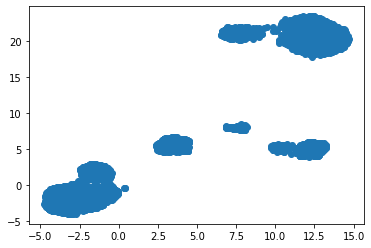

In [17]:
plt.scatter(joined_embeddings[:, 0], joined_embeddings[:, 1])
plt.show()

In [18]:
print(company_embeddings)

[[ 2.8511984  4.9711328]
 [12.6158905  5.0920553]
 [-1.1429101 -2.6001184]
 ...
 [ 2.630107   5.2896667]
 [11.791956   4.123386 ]
 [ 3.9484985  5.4020424]]


# Carlo embeddings HGT

In [19]:
carlo_com_embed = open('hgt_com_embeddings.pkl','rb')
carlo_com_embed = pickle.load(carlo_com_embed)

carlo_inv_embed = open('hgt_inv_embeddings.pkl','rb')
carlo_inv_embed = pickle.load(carlo_inv_embed)

print(carlo_com_embed.shape)
print(carlo_inv_embed.shape)

torch.Size([11135, 256])
torch.Size([18377, 256])


In [20]:
# company_embeddings = company_embeddings.detach().numpy()
# investor_company_embeddings = investor_company_embeddings.detach().numpy()
reducer = umap.UMAP()

carlo_com_embed = carlo_com_embed.detach().numpy()
carlo_inv_embed = carlo_inv_embed.detach().numpy()

carlo_com_embed = reducer.fit_transform(carlo_com_embed)
carlo_inv_embed = reducer.fit_transform(carlo_inv_embed)

print(carlo_com_embed)
print(carlo_inv_embed)

[[ 9.60386   14.104332 ]
 [ 8.49381   13.017826 ]
 [10.410431   9.2712   ]
 ...
 [14.403484  -1.1114426]
 [10.973741  13.809977 ]
 [10.359436  12.28215  ]]
[[16.630362   11.299892  ]
 [ 3.4805975   9.110713  ]
 [ 4.320875    0.23470272]
 ...
 [-3.2051432   2.1366966 ]
 [ 8.694367   14.009724  ]
 [14.597041   11.624157  ]]


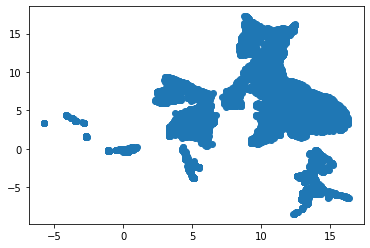

In [21]:
plt.scatter(carlo_com_embed[:, 0], carlo_com_embed[:, 1],)
plt.show()

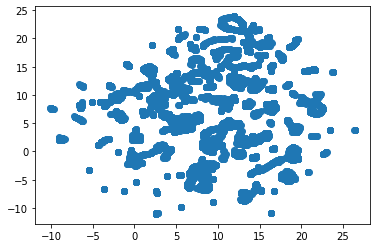

In [22]:
plt.scatter(carlo_inv_embed[:, 0], carlo_inv_embed[:, 1],)
plt.show()

In [23]:
joined_carlo_embeddings = np.concatenate((carlo_com_embed, carlo_inv_embed), axis=0)
print(joined_carlo_embeddings[:10])

[[ 9.60386   14.104332 ]
 [ 8.49381   13.017826 ]
 [10.410431   9.2712   ]
 [13.530699   4.3043447]
 [ 7.688454   7.5913863]
 [14.829339  -2.691356 ]
 [10.622879  11.468396 ]
 [12.9602     4.392204 ]
 [ 5.4746447 -2.41512  ]
 [11.500462  12.754278 ]]


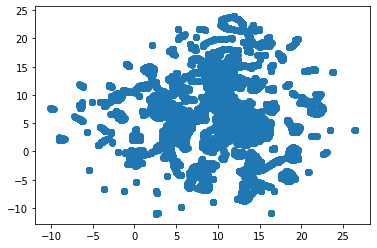

In [24]:
plt.scatter(joined_carlo_embeddings[:, 0], joined_carlo_embeddings[:, 1])
plt.show()

In [25]:
company_ids_carlo = open('company_ids.pkl','rb')
company_ids_carlo = pickle.load(company_ids_carlo)

investor_ids_carlo = open('investor_ids.pkl','rb')
investor_ids_carlo = pickle.load(investor_ids_carlo)

pd_company_ids_carlo = pd.DataFrame(list(company_ids_carlo.keys()))
pd_investor_ids_carlo = pd.DataFrame(list(investor_ids_carlo.keys()))

In [26]:
pd_company_ids_carlo['Embedding'] = carlo_com_embed.tolist()
pd_investor_ids_carlo['Embedding'] = carlo_inv_embed.tolist()

pd_company_ids_carlo = pd_company_ids_carlo.rename(columns={0: "CompanyID"})
pd_investor_ids_carlo = pd_investor_ids_carlo.rename(columns={0: "InvestorID"})

In [27]:
#Import the data
processed_company_data = pd.read_csv('processed_company_data.csv', sep=",")
processed_investor_data = pd.read_csv('processed_investor_data.csv', sep=",")

/home/ramon/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
merge_company_with_embeddings = pd.merge(processed_company_data, pd_company_ids_carlo, how='inner')
merge_investor_with_embeddings = pd.merge(processed_investor_data, pd_investor_ids_carlo, how='inner')

In [29]:
company_id_with_embedding_carlo = merge_company_with_embeddings[['CompanyID', 'Embedding']]
investor_id_with_embedding_carlo = merge_investor_with_embeddings[['InvestorID', 'Embedding']]

In [30]:
json_company_id_with_embedding_carlo = company_id_with_embedding_carlo.to_json(orient="records")
json_investor_id_with_embedding_carlo = investor_id_with_embedding_carlo.to_json(orient="records")

print(json_company_id_with_embedding_carlo)

[{"CompanyID":"100020-70","Embedding":[11.7041540146,7.4906773567]},{"CompanyID":"100083-16","Embedding":[9.7111263275,8.5231533051]},{"CompanyID":"100143-55","Embedding":[10.6816225052,10.8168878555]},{"CompanyID":"100148-32","Embedding":[11.4210891724,8.2230968475]},{"CompanyID":"100153-36","Embedding":[11.6518030167,13.8823833466]},{"CompanyID":"100164-61","Embedding":[9.6845912933,10.0190048218]},{"CompanyID":"100211-68","Embedding":[11.148897171,8.4163818359]},{"CompanyID":"100217-98","Embedding":[11.5987348557,8.5821437836]},{"CompanyID":"100218-07","Embedding":[9.0805883408,9.8223333359]},{"CompanyID":"100304-02","Embedding":[5.7734069824,6.0851931572]},{"CompanyID":"100326-79","Embedding":[12.919793129,6.2556605339]},{"CompanyID":"100359-46","Embedding":[5.0516180992,5.1948695183]},{"CompanyID":"100360-00","Embedding":[9.5446481705,11.4622573853]},{"CompanyID":"100419-40","Embedding":[11.6270456314,14.5555114746]},{"CompanyID":"100564-84","Embedding":[5.9195132256,6.0479941368]

In [31]:
with open('company_id_with_embedding_carlo.json', 'w') as f:
    f.write(json_company_id_with_embedding_carlo)
    
with open('investor_id_with_embedding_carlo.json', 'w') as f:
    f.write(json_investor_id_with_embedding_carlo)

In [32]:
#Create new processed csv files
merge_company_with_embeddings.to_csv('company_with_embeddings_carlo.csv', index=False)
merge_investor_with_embeddings.to_csv('investor_with_embeddings_carlo.csv', index=False)

# Carlo embeddings RGCN

In [33]:
rgcn_carlo_com_embed = open('rgcn_com_embeddings.pkl','rb')
rgcn_carlo_com_embed = pickle.load(rgcn_carlo_com_embed)

rgcn_carlo_inv_embed = open('rgcn_inv_embeddings.pkl','rb')
rgcn_carlo_inv_embed = pickle.load(rgcn_carlo_inv_embed)

print(rgcn_carlo_com_embed.shape)
print(rgcn_carlo_inv_embed.shape)

torch.Size([11084, 256])
torch.Size([18377, 256])


In [34]:
reducer = umap.UMAP()

rgcn_carlo_com_embed = rgcn_carlo_com_embed.detach().numpy()
rgcn_carlo_inv_embed = rgcn_carlo_inv_embed.detach().numpy()

rgcn_carlo_com_embed = reducer.fit_transform(rgcn_carlo_com_embed)
rgcn_carlo_inv_embed = reducer.fit_transform(rgcn_carlo_inv_embed)

print(rgcn_carlo_com_embed)
print(rgcn_carlo_inv_embed)

[[-0.9207478 12.681931 ]
 [-6.189597  -2.0965528]
 [ 4.599416   4.6393666]
 ...
 [ 4.4822707 -1.5289025]
 [ 8.579479   5.9416814]
 [ 6.1865926 -4.441479 ]]
[[-8.132823   2.2773283]
 [20.094091   5.4723096]
 [ 4.6187434 13.016221 ]
 ...
 [19.990946   4.7218137]
 [ 1.9586105 -5.2354584]
 [-6.6314073  6.4967456]]


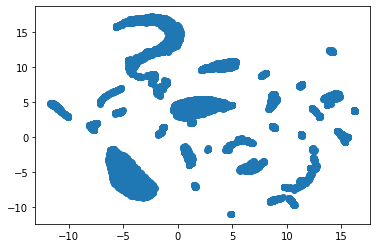

In [35]:
plt.scatter(rgcn_carlo_com_embed[:, 0], rgcn_carlo_com_embed[:, 1],)
plt.show()

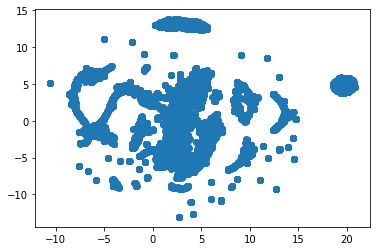

In [36]:
plt.scatter(rgcn_carlo_inv_embed[:, 0], rgcn_carlo_inv_embed[:, 1],)
plt.show()

In [37]:
rgcn_joined_carlo_embeddings = np.concatenate((rgcn_carlo_com_embed, rgcn_carlo_inv_embed), axis=0)
print(rgcn_joined_carlo_embeddings[:10])

[[-0.9207478 12.681931 ]
 [-6.189597  -2.0965528]
 [ 4.599416   4.6393666]
 [ 6.366896  -4.1337614]
 [ 8.543223   4.3006153]
 [-1.169321  12.705789 ]
 [-1.8446748  6.684526 ]
 [-4.4914765 16.473536 ]
 [-3.764512  16.91248  ]
 [13.896378  12.426086 ]]


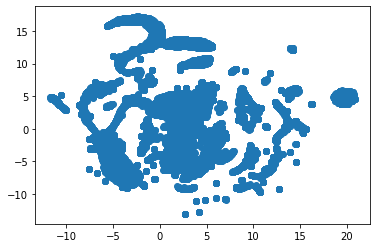

In [38]:
plt.scatter(rgcn_joined_carlo_embeddings[:, 0], rgcn_joined_carlo_embeddings[:, 1])
plt.show()

In [39]:
company_ids_carlo = open('rgcn_company_keys.pkl','rb')
company_ids_carlo = pickle.load(company_ids_carlo)

investor_ids_carlo = open('investor_ids.pkl','rb')
investor_ids_carlo = pickle.load(investor_ids_carlo)

pd_company_ids_carlo = pd.DataFrame(list(company_ids_carlo.keys()))
pd_investor_ids_carlo = pd.DataFrame(list(investor_ids_carlo.keys()))
# print(list(company_ids_carlo.keys())[:5])

In [40]:
pd_company_ids_carlo['Embedding'] = rgcn_carlo_com_embed.tolist()
pd_investor_ids_carlo['Embedding'] = rgcn_carlo_inv_embed.tolist()

pd_company_ids_carlo = pd_company_ids_carlo.rename(columns={0: "CompanyID"})
pd_investor_ids_carlo = pd_investor_ids_carlo.rename(columns={0: "InvestorID"})

In [41]:
#Import the data
processed_company_data = pd.read_csv('processed_company_data.csv', sep=",")
processed_investor_data = pd.read_csv('processed_investor_data.csv', sep=",")

/home/ramon/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [42]:
merge_company_with_embeddings = pd.merge(processed_company_data, pd_company_ids_carlo, how='inner')
merge_investor_with_embeddings = pd.merge(processed_investor_data, pd_investor_ids_carlo, how='inner')

In [43]:
company_id_with_embedding_carlo = merge_company_with_embeddings[['CompanyID', 'Embedding']]
investor_id_with_embedding_carlo = merge_investor_with_embeddings[['InvestorID', 'Embedding']]

In [44]:
json_company_id_with_embedding_carlo = company_id_with_embedding_carlo.to_json(orient="records")
json_investor_id_with_embedding_carlo = investor_id_with_embedding_carlo.to_json(orient="records")

print(json_company_id_with_embedding_carlo)

[{"CompanyID":"100020-70","Embedding":[7.3258843422,-4.2248921394]},{"CompanyID":"100083-16","Embedding":[-1.8640743494,6.8385472298]},{"CompanyID":"100143-55","Embedding":[6.3970189095,-0.5219197869]},{"CompanyID":"100148-32","Embedding":[0.1048238501,4.6536011696]},{"CompanyID":"100153-36","Embedding":[6.0402936935,-4.4782676697]},{"CompanyID":"100164-61","Embedding":[6.3325943947,-4.5192866325]},{"CompanyID":"100211-68","Embedding":[-0.0075956085,15.7917089462]},{"CompanyID":"100217-98","Embedding":[7.4080934525,-4.2896709442]},{"CompanyID":"100218-07","Embedding":[-1.416893959,7.3134427071]},{"CompanyID":"100304-02","Embedding":[-1.6395331621,0.6166363955]},{"CompanyID":"100326-79","Embedding":[-4.2050876617,-5.5930967331]},{"CompanyID":"100359-46","Embedding":[-1.2530508041,7.4490842819]},{"CompanyID":"100360-00","Embedding":[6.7242426872,-4.6751942635]},{"CompanyID":"100419-40","Embedding":[5.66882658,-0.350338608]},{"CompanyID":"100564-84","Embedding":[1.5429828167,5.1666193008]

In [45]:
with open('rgcn_company_id_with_embedding_carlo.json', 'w') as f:
    f.write(json_company_id_with_embedding_carlo)
    
with open('rgcn_investor_id_with_embedding_carlo.json', 'w') as f:
    f.write(json_investor_id_with_embedding_carlo)

In [46]:
#Create new processed csv files
merge_company_with_embeddings.to_csv('rgcn_company_with_embeddings_carlo.csv', index=False)
merge_investor_with_embeddings.to_csv('rgcn_investor_with_embeddings_carlo.csv', index=False)

# Create the data files with the HGT embeddings

In [47]:
#Import the data
processed_company_data = pd.read_csv('processed_company_data.csv', sep=",")
processed_investor_data = pd.read_csv('processed_investor_data.csv', sep=",")

In [48]:
print(len(company_embeddings))
print(len(investor_company_embeddings))

9779
7883


In [49]:
print(len(processed_company_data))
print(len(processed_investor_data))

9779
7883


In [50]:
processed_company_data['Embedding'] = company_embeddings.tolist()
processed_investor_data['Embedding'] = investor_company_embeddings.tolist()

In [51]:
company_with_hgt_embedddings = processed_company_data
investor_with_hgt_embedddings = processed_investor_data

In [52]:
print(company_embeddings[:5])
print(investor_company_embeddings[:5])

[[ 2.8511984  4.9711328]
 [12.6158905  5.0920553]
 [-1.1429101 -2.6001184]
 [-2.891367  -2.2042933]
 [11.990798   5.2986364]]
[[13.03264   19.691486 ]
 [12.329509  21.0606   ]
 [14.541085  20.389605 ]
 [10.857772  21.954348 ]
 [13.1611805 20.445269 ]]


In [53]:
print(company_with_hgt_embedddings['Embedding'].head())
print(investor_with_hgt_embedddings['Embedding'].head())

0       [2.851198434829712, 4.971132755279541]
1      [12.615890502929688, 5.092055320739746]
2     [-1.142910122871399, -2.600118398666382]
3    [-2.891366958618164, -2.2042932510375977]
4      [11.990797996520996, 5.298636436462402]
Name: Embedding, dtype: object
0     [13.03264045715332, 19.691486358642578]
1     [12.329508781433105, 21.06060028076172]
2    [14.541085243225098, 20.389604568481445]
3    [10.857771873474121, 21.954347610473633]
4     [13.16118049621582, 20.445268630981445]
Name: Embedding, dtype: object


In [54]:
company_id_with_embedding = company_with_hgt_embedddings[['CompanyID', 'Embedding']]
investor_id_with_embedding = investor_with_hgt_embedddings[['InvestorID', 'Embedding']]

In [55]:
json_company_id_with_embedding = company_id_with_embedding.to_json(orient="records")
json_investor_id_with_embedding = investor_id_with_embedding.to_json(orient="records")

print(json_company_id_with_embedding)

[{"CompanyID":"100020-70","Embedding":[2.8511984348,4.9711327553]},{"CompanyID":"100083-16","Embedding":[12.6158905029,5.0920553207]},{"CompanyID":"100143-55","Embedding":[-1.1429101229,-2.6001183987]},{"CompanyID":"100148-32","Embedding":[-2.8913669586,-2.204293251]},{"CompanyID":"100153-36","Embedding":[11.9907979965,5.2986364365]},{"CompanyID":"100164-61","Embedding":[-2.8566074371,-1.6325073242]},{"CompanyID":"100211-68","Embedding":[-3.0078303814,-2.0229763985]},{"CompanyID":"100217-98","Embedding":[-0.1309863031,-1.3964446783]},{"CompanyID":"100218-07","Embedding":[-1.6636029482,2.7869625092]},{"CompanyID":"100304-02","Embedding":[-1.5979388952,-0.3149420917]},{"CompanyID":"100326-79","Embedding":[-2.4665439129,-0.1566815227]},{"CompanyID":"100359-46","Embedding":[-1.542235136,-3.03936553]},{"CompanyID":"100360-00","Embedding":[12.9329710007,4.7937560081]},{"CompanyID":"100419-40","Embedding":[12.1257858276,5.0691399574]},{"CompanyID":"100564-84","Embedding":[12.3381309509,5.7303

# Create the files

In [56]:
# with open('company_id_with_embedding.json', 'w') as f:
#     f.write(json_company_id_with_embedding)
    
# with open('investor_id_with_embedding.json', 'w') as f:
#     f.write(json_investor_id_with_embedding)

In [57]:
#Create new processed csv files
# company_with_hgt_embedddings.to_csv('company_with_hgt_embedddings.csv', index=False)
# investor_with_hgt_embedddings.to_csv('investor_with_hgt_embedddings.csv', index=False)